In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
import nltk
from nltk.probability import FreqDist
from wordcloud import WordCloud, STOPWORDS
import plotly
import cufflinks
import warnings
#nltk.download("stopwords")
plt.style.use('ggplot')
warnings.filterwarnings('ignore')
%matplotlib inline

# 2020 Kaggle Data Science Survey Analysis

The 2020 Kaggle Data Science and Machine Learning Survey was conducted by Kaggle to get a comprehensive view of the state of data science and machine learning adoption and usage. The survey was live for 3.5 weeks in October 2020 and collected 20,036 responses.

The dataset was used to explore reponses from Data Scientists to understand the programming languages, BI tools, preferred IDE's and platforms used. Also, on common topics, libraries and tools used for machine learning, and how they publicly share their work and resources used to gain knowledge about current trends.

This information can provide insights for both aspiring and experienced individuals in the field of data science. (Note: These insights are based on the survey responses and limited only to the question asked in the survey. There may be other topics which are integral in Data Science.)

In [2]:
data = pd.read_csv("data//kaggle_survey_2020_responses.csv")
cols = list(data.loc[0])
df = data.iloc[1:].reset_index(drop = True)
df.columns = cols

In [3]:
old_names = list(df.columns[:7])
new_names = ['Duration', 'Age','Gender','Country', 'HighestEducation','CurrentRole', 'YrsCodingExperience']
df.rename(columns=dict(zip(old_names, new_names)), inplace=True)

In [4]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords.append('following')
tokenizer = RegexpTokenizer(r'\w+')

Some of the questions that can be answered for aspiring and new data scientists are:
1. What are the popular programming languages, databases, BI tools and IDE's used in this field?
2. What are some common machine learning algorithms and frameworks to be aware of?
3. What are the platforms used to learn and share data science work?
4. What are the tools and frameworks that can be useful to know in that coming future?  

Only respondents whose current role is a Data Scientist are considered for the following analysis.


In [5]:
def maintopicwords(cols_list):
    cols = [] 
    for m in cols_list:
        mrepl = m.replace("Select all that apply", "").replace("- Selected Choice","").replace("next 2 years","")
        question = mrepl.split("-", maxsplit = 1)[0].lower()
        choice = mrepl.split("-", maxsplit = 1)[1].strip()
        tokens = tokenizer.tokenize(question)
        qparts = [t for t in tokens if t not in stopwords]
        p1 = " ".join(qparts)
        cols.append(p1+' - '+choice)
    return cols

In [6]:
old_cols = list(df.loc[:,df.nunique() == 1].columns)
new_cols = maintopicwords(old_cols)
df.rename(columns = dict(zip(old_cols, new_cols)), inplace = True)
df.drop(columns = list(df.columns[(df.columns.str.contains('None'))|(df.columns.str.contains('Other'))]), inplace = True)
df_ds = df[(df['CurrentRole'] == 'Data Scientist')&(df['YrsCodingExperience'] != 'I have never written code')]

## Demographic of the Survey Respondents

### Country they reside in

In [7]:
import plotly.graph_objs as go 
from plotly.offline import init_notebook_mode,iplot,plot
init_notebook_mode(connected=True)

In [8]:
ds_map = df_ds.Country.value_counts().reset_index().rename(columns = {'Country':'Count', 'index':'Country'})
Total = sum(ds_map['Count'])
ds_map['Pct_Count'] = '%Count = '+(((ds_map['Count']/Total)*100).round(1)).astype('str')+'%'

In [9]:
data = dict(
        type = 'choropleth',
        colorscale = 'Viridis_r',
        locations = ds_map['Country'],
        locationmode = "country names",
        z = ds_map['Count'],
        text = ds_map['Pct_Count'],
        colorbar = {'title' : 'Number of Respondents'},
      )

In [10]:
layout = dict(title = 'Country of Respondents ',
              geo = dict(projection = {'type':'mercator'})
             )

There are respondents from 55 countries. Top countries are India (22%) and US (15%), followed by Brazil (5%), UK (4%) and Russia (3%).
The interactive map below shows the number and percentage of respondents from countries around the world. 

In [11]:
choromap = go.Figure(data = [data],layout = layout)
choromap.update_layout(height = 650, width = 900, margin = {'l':5, 'r':5})
iplot(choromap,validate=False)

India and US together constitute ~36% of respondents, the results can be influenced by the adoptions and trends followed in these two countries. 

### Education

The highest education completed is shown below. The others category consists of respondents who have some/no formal education past high school and those who prefer not answer.

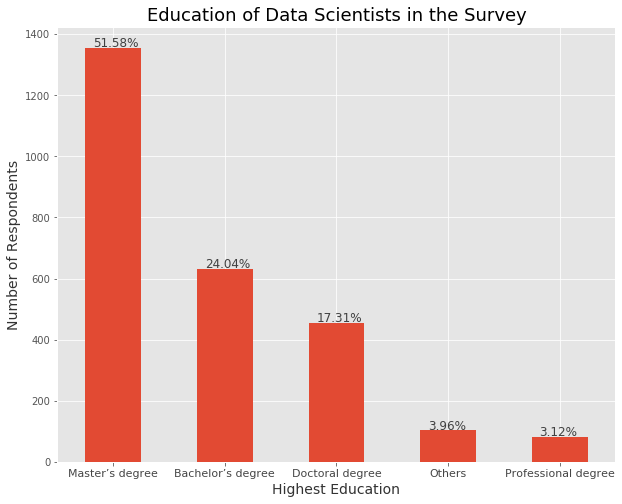

In [12]:
ed_sel = (df_ds.HighestEducation == 'Master’s degree') | (df_ds.HighestEducation == 'Doctoral degree') | (df_ds.HighestEducation == 'Bachelor’s degree') | (df_ds.HighestEducation == 'Professional degree')
df_ds.loc[~ed_sel, 'HighestEducation'] = "Others"
#plot
ax = df_ds.HighestEducation.value_counts().plot(kind = 'bar', figsize = (10,8))
ax.set_alpha(0.8)
ax.set_title("Education of Data Scientists in the Survey", fontsize=18)
ax.set_ylabel("Number of Respondents", fontsize=14, color = '0.2')
ax.set_xlabel("Highest Education",  fontsize=14, color = '0.2')
ax.set_xticklabels(fontdict = {'fontsize':11},color = '0.27',labels = ['Master’s degree','Bachelor’s degree','Doctoral degree','Others','Professional degree'], rotation = 0)

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_height())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+.07, i.get_height()+2, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=12, color='0.25')

68.28% of data scientists have a Master's degree or above. This also means that there are ~30% with bachelor's or lesser degree who are data scientists. Considering the abundance of online learning resources, a Master's degree or above may not be essential in the future.

### Years of Coding Experience

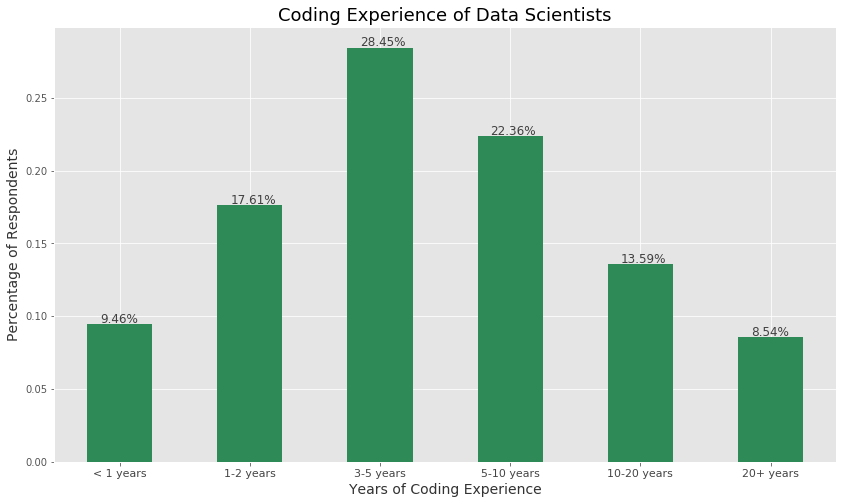

In [13]:
codingexp_order = ['< 1 years','1-2 years',  '3-5 years','5-10 years', '10-20 years', '20+ years']
ax = df_ds.YrsCodingExperience.value_counts(normalize = True).loc[codingexp_order].plot(kind = 'bar', figsize = (14,8), color = 'seagreen')
ax.set_alpha(0.8)
ax.set_title("Coding Experience of Data Scientists", fontsize=18)
ax.set_ylabel("Percentage of Respondents", fontsize=14, color = '0.2')
ax.set_xlabel("Years of Coding Experience",  fontsize=14, color = '0.2')
ax.set_xticklabels(fontdict = {'fontsize':11},color = '0.27',labels = codingexp_order, rotation = 0)

# set individual bar labels using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+0.1, i.get_height()+0.001, \
            str(round((i.get_height())*100, 2))+'%', fontsize=12, color='0.25')


Coding experience or knowing how to code is important in this field. Majority of the data scientists have more than 2 years of coding experience.

### Age and Gender

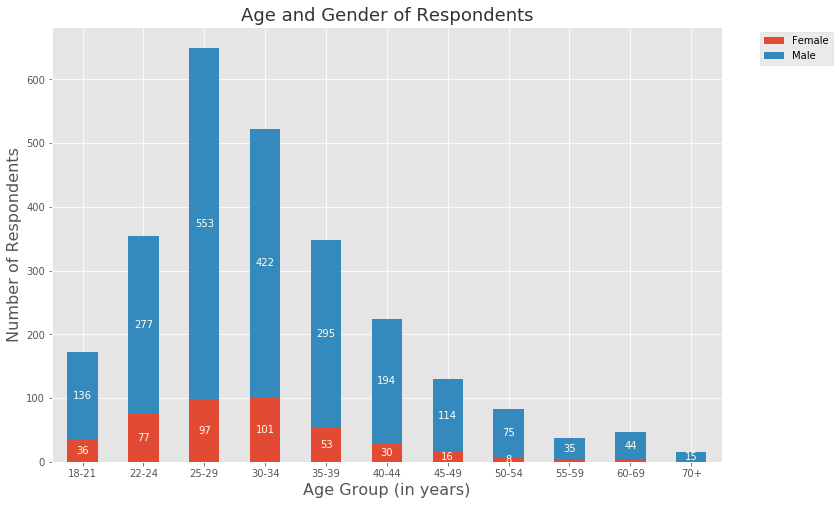

In [14]:
age_gender = df_ds[(df_ds.Gender == 'Man') | (df_ds.Gender == 'Woman')].groupby(['Age', 'Gender']).size().reset_index()
df_ag = pd.pivot(age_gender, index = 'Age', columns = 'Gender').reset_index()
df_ag.columns = ['Age','Male', 'Female']
#plot
ax = df_ag[['Age','Female','Male']].set_index('Age').plot(stacked=True, kind='bar', figsize=(12, 8), rot='horizontal')

# .patches is everything inside of the chart
for i in ax.patches:
    # Find where everything is located
    height = i.get_height()#height of the bar
    width = i.get_width()#width of the bar
    x = i.get_x()#starting (left) x position of bar in the plot 
    y = i.get_y()#starting (bottom) y position of bar in the plot
    
    # The height of the bar is the data value and can be used as the label
    label_text = int(height) # f'{height:.2f}' to format decimal values
    
    # ax.text(x, y, text)
    label_x = x + width / 2
    label_y = y + height / 2

    # plot only when height is greater than specified value
    if height > 5:
        ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=10, color = 'ivory')
    
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')    
ax.set_ylabel("Number of Respondents", fontsize=16)
ax.set_xlabel("Age Group (in years)", fontsize=16)
ax.set_title("Age and Gender of Respondents", fontsize = 18, color = '0.2')
plt.show()

82% are male, 16.4% are female and 1.6% belong to other gender descriptions. Majority of the data scientists are males. 


Dominating age group is 25-34 years comprising 45% of the respondents, followed by 22-24 years and 35-39 years with 14% each. This can include people in different stages of their career.

## Technical Skills of the Data Scientists

### Programming languages, Integrated Development Environments (IDE) and visualization libraries 

In [15]:
def convert_to_single_list(series):
    text =[]
    for val in series:
        if len(val)> 1:
            text.extend(val)
    return text

In [16]:
def dataframe_to_wordcloudplot(dfw, bg_color, figure_size, title):
    dfwc = dfw.apply(lambda x: x.str.replace(r" ", ""))
    series = dfwc.apply(lambda x: list(x.dropna()), axis = 1).reset_index(drop = True)
    text = convert_to_single_list(series)
    freq = dict(nltk.FreqDist(text))
    wordcloud = WordCloud(max_words = 100,background_color = bg_color).generate_from_frequencies(freq)
    fig = plt.figure(figsize = figure_size)
    plt.title(title)
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()   

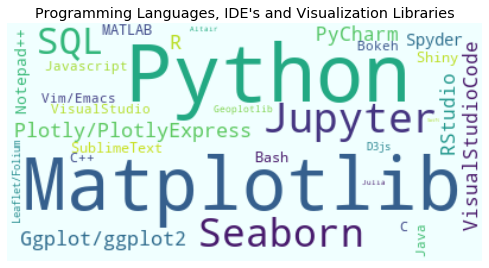

In [17]:
plang_cols = list(df_ds.columns[(df_ds.columns.str.contains('programming languages use regular basis'))|(df_ds.columns.str.contains('data visualization libraries tools use regular basis'))|(df_ds.columns.str.contains('integrated development environments ide use regular basis'))])
df_plang = df_ds[plang_cols].apply(lambda x: x.str.replace(r"\(.*\)", ""))
wc_lang = dataframe_to_wordcloudplot(df_plang, bg_color = "azure", figure_size = (7,10), title = "Programming Languages, IDE's and Visualization Libraries")

Python, SQL and R are top languages for Data Science. Jupyter (notebooks, lab), Visual Studio Code and PyCharm are the common IDE's used.  

Matplotlib, Seaborn and Plotly are popular data visualization, libraries all of which are in Python. Python is the most suggested language for aspiring data scientists among the three.  

### Databases, Business Intelligence Tools and Cloud Platforms 

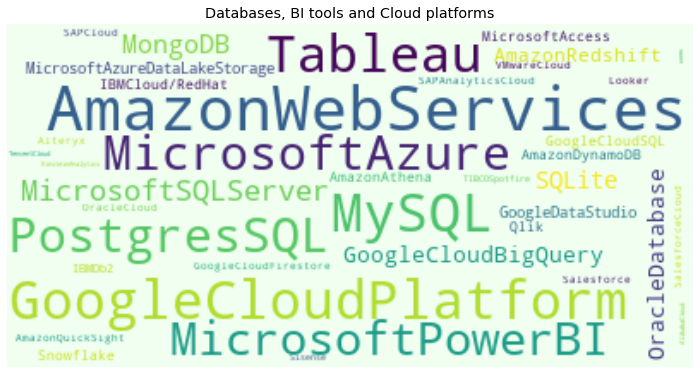

In [18]:
clbidb_cols = list(df_ds.columns[(df_ds.columns.str.contains("cloud computing platforms use regular basis"))|(df_ds.columns.str.contains("business intelligence tools use regular basis"))|(df_ds.columns.str.contains("big data products relational databases data warehouses data lakes similar use regular basis"))])
df_clbidb = df_ds[clbidb_cols].apply(lambda x: x.str.replace(r"\(.*\)", ""))
wc_clbidb = dataframe_to_wordcloudplot(df_clbidb, bg_color = "honeydew", figure_size = (10,5), title = 'Databases, BI tools and Cloud platforms')

#### Top 3 Tools and Platforms used are
- Databases - MySQL, PostgresSQL and Microsoft SQL Server
- Business Intelligence Tools - Tableau, Microsoft Power BI and Google Data Studio
- Cloud Computing Platforms - Amazon Web Services, Google Cloud Platform and Microsoft Azure

### Popular Machine Learning Algorithms and Frameworks

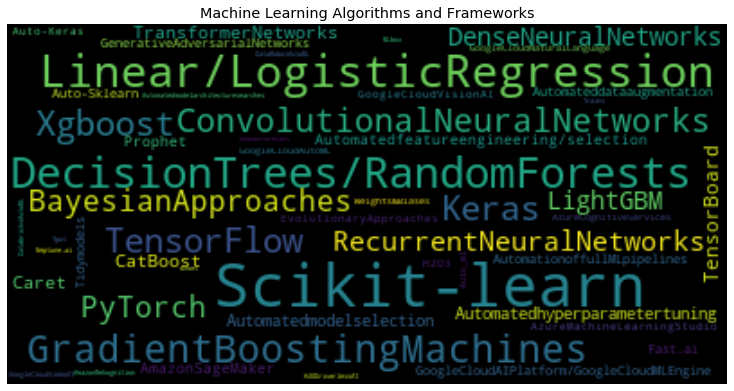

In [19]:
ml_cols = df_ds.columns[(((df_ds.columns.str.contains('machine learning'))|(df_ds.columns.str.contains('ml')))&(df_ds.columns.str.contains('regular basis')))|(df_ds.columns.str.contains('use tools help manage machine learning experiments'))]
df_ml = df_ds[ml_cols].apply(lambda x: x.str.replace(r" or ","/")).apply(lambda x: x.str.replace(r"\(.*\)", ""))
wc_clbidb = dataframe_to_wordcloudplot(df_ml, bg_color = "black", figure_size = (10,8), title = 'Machine Learning Algorithms and Frameworks')

#### Commonly used machine learning algorithms:
- Linear/Logistic Regression
- Decision Trees/Random Forests
- Gradient Boosting Machines (Ex: LightGBM, XgBoost)
- Convolutional Neural Networks
<br>
  
#### Popular machine learning frameworks:
- Scikit-learn
- Keras
- Tensor Flow
- XgBoost  


#### Automated machine learning tools are preferred mostly for *Hyperparameter Tuning*, *Model Selection* and *Feature Engineering*. Some of the tools used for this are *Auto-Sklearn*, *Auto-Keras* and *Auto-ml*.



### Resources used to learn and publicly share work

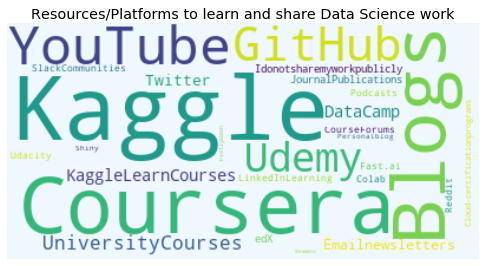

In [20]:
shln_cols = df_ds.columns[(df_ds.columns.str.contains('favorite media sources report data science topics'))|(df_ds.columns.str.contains('platforms begun completed data science courses'))|(df_ds.columns.str.contains('publicly share deploy data analysis machine learning applications'))]
df_shln = df_ds[shln_cols].apply(lambda x: x.str.replace(r"\(.*\)", ""))
df_shln.drop(columns = list(df_ds.columns[df_ds.columns.str.contains("i do not share my work publicly")]), inplace = True)
wc_shln = dataframe_to_wordcloudplot(df_shln, bg_color = "aliceblue", figure_size = (7,6), title = 'Resources/Platforms to learn and share Data Science work')

Coursera is the most popular for Data Sciences courses, followed by Udemy and University Courses. Favorite media sources are Kaggle, Blogs and Youtube videos. 

Platforms like GitHub and Kaggle are used to publicly share data science and machine learning work.


### Technical skills Data Scientists hope to learn in the next two years

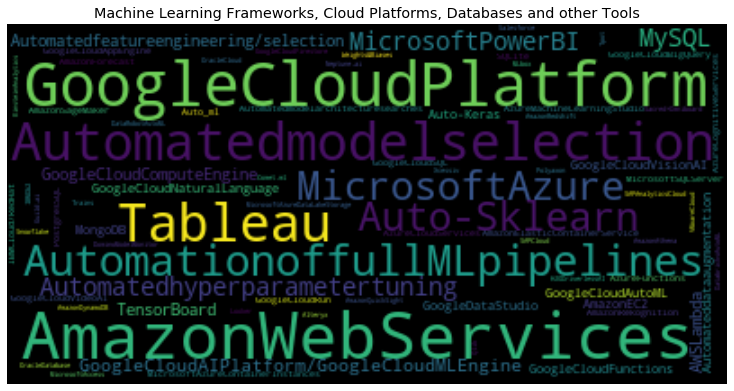

In [21]:
befa_cols = df_ds.columns[df_ds.columns.str.contains("hope become familiar")]
df_befa = df_ds[befa_cols].apply(lambda x: x.str.replace(r"\(.*\)", ""))
wc_befa = dataframe_to_wordcloudplot(df_befa, bg_color = "black", figure_size = (10,6), title = 'Machine Learning Frameworks, Cloud Platforms, Databases and other Tools')

### Data Scientists are gearing towards learning more about:
- **Cloud Computing Products/Services related to Data Science, Machine Learning and AI offered by**
    - Amazon Web Services, Google Cloud Platform, Microsoft Azure  
  <br>
- **Automated Machine Learning Tools for**
    - Automated Model Selection (Auto-Sklearn)
    - Automation of Full ML Pipelines (Auto-Keras)
    - Automated Feature Engineering and Hyperparameter Tuning    
<br>
- **Business Intelligence Tools such as**
    - Tableau
    - Microsoft Power BI
    - Google Data Studio

The trend is moving towards understanding relevant cloud computing services as many industries are adopting cloud infrastructure for their data. Also, full/partial automation of the machine learning pipeline has gained momentum.  <br>If you have just started working as a data scientist, knowledge of these topics and tools can keep you up to date (valuable and relevant) in the field in the coming future.